In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy
from tqdm import trange
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms
from typing import List, Any, Tuple, Optional
from collections import OrderedDict
import EarlyStopping

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

6

In [4]:
torch.cuda.get_device_name()

'NVIDIA RTX A5000'

In [5]:
print("144 or 37")

144 or 37


In [6]:
# Hyperparameters for training
num_rounds = 50
local_rounds = 10
num_clients = 10  # Total number of clients
num_selected = 10  # Number of selected clients per round
local_bs = 10
lr = 0.001
num_channels = 3
num_classes = 10
test_bs = 128
gamma = 0.1
milestones = [0.5 * num_rounds, 0.75 * num_rounds]

In [7]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda', index=5)

In [9]:
#ResNet9
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [10]:
class ResNet9(nn.Module):
    def __init__(
            self, 
            in_channels, 
            num_classes, 
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.SiLU,
            grid_eps=0.02,
            grid_range=[-1, 1],
            ):
        super(ResNet9, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [11]:
class CIFAR10_truncated(Dataset):

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = datasets.CIFAR10(self.root, self.train, self.transform, self.target_transform, self.download)

        data = np.array(cifar_dataobj.data)
        target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

In [12]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])])

In [13]:
# CIFAR10 Data loading
train_dataset = CIFAR10_truncated('./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR10_truncated('./data', train=False, download=True, transform=transform_test)

X_train, y_train = train_dataset.data, train_dataset.target
X_test, y_test = test_dataset.data, test_dataset.target

Files already downloaded and verified
Files already downloaded and verified


In [14]:
def record_net_data_stats(y_train, net_dataidx_map):

    net_cls_counts = {}

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp

    #print('Data statistics: %s' % str(net_cls_counts))

    return net_cls_counts

In [15]:
class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.targets = dataset.targets
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

In [16]:
# for IID case
def generate_iid_cifar(X_train,y_train, num_of_clients):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param n_nets: Number of clients
    :return: Tuple containing train and test datasets, data index map for each client, and train data class counts
    """
    
    n_train = X_train.shape[0]

    # Shuffle and partition the data
    idxs = np.arange(n_train)
    np.random.shuffle(idxs)

    net_data_idx_map = {}
    batch_idxs = np.array_split(idxs, num_of_clients)

    for i in range(num_of_clients):
        net_data_idx_map[i] = batch_idxs[i]

    traindata_class_counts = record_net_data_stats(y_train, net_data_idx_map)

    return net_data_idx_map, traindata_class_counts


In [17]:
def generate_noniid_cifar(X_train,y_train, num_of_clients, alpha=0.5):
    """
    Sample non I.I.D. client data from CIFAR10 dataset
    :param dataset: 
    :param num_users: 
    :return: 
    """

    n_train = len(X_train.shape)

    min_size = 0
    K = 10
    N = len(y_train)
    net_dataidx_map = {}

    while min_size < 10:
        idx_batch = [[] for _ in range(num_of_clients)]
        for k in range(K):
            idx_k = np.where(y_train == k)[0]
            np.random.shuffle(idx_k)
            proportions = np.random.dirichlet(np.repeat(alpha, num_of_clients))
            ## Balance
            proportions = np.array([p*(len(idx_j)<N/num_of_clients) for p,idx_j in zip(proportions,idx_batch)])
            proportions = proportions/proportions.sum()
            proportions = (np.cumsum(proportions)*len(idx_k)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_batch,np.split(idx_k,proportions))]
            min_size = min([len(idx_j) for idx_j in idx_batch])

    for j in range(num_of_clients):
        np.random.shuffle(idx_batch[j])
        net_dataidx_map[j] = idx_batch[j]
    traindata_class_counts = record_net_data_stats(y_train, net_dataidx_map)

    return net_dataidx_map, traindata_class_counts

In [18]:
#iid_dataidx_map, iid_traindata_cls_counts = generate_iid_cifar(X_train,y_train, num_clients)

In [19]:
noniid_dataidx_map, noniid_traindata_cls_counts = generate_noniid_cifar(X_train,y_train, num_clients)

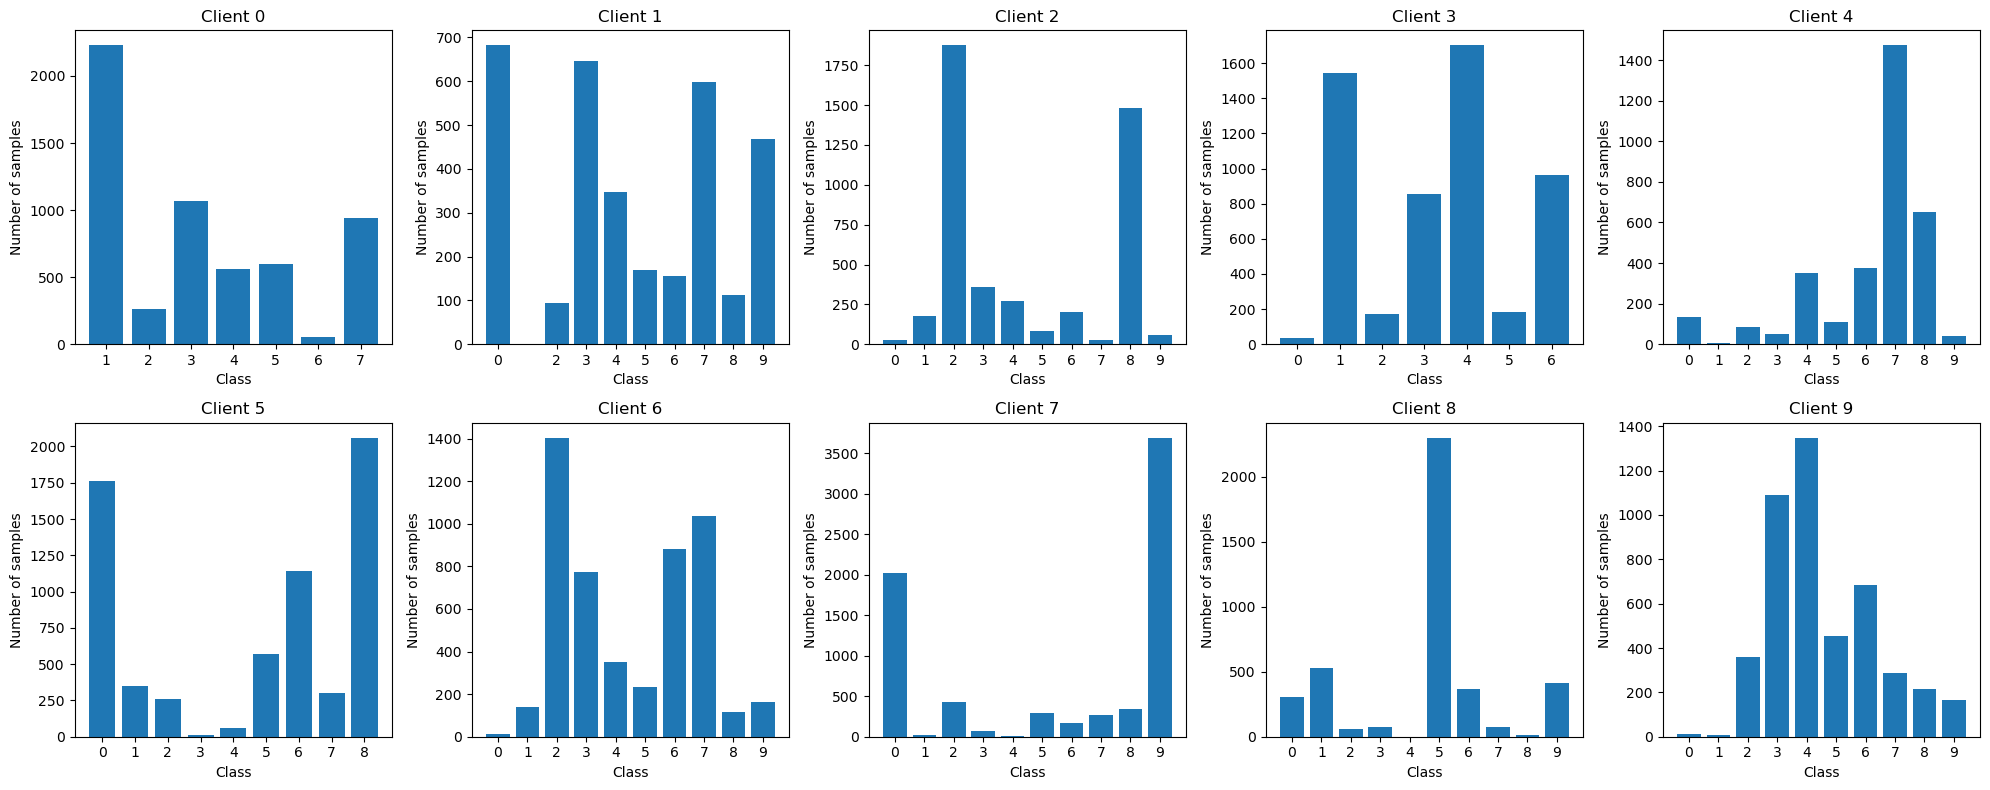

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from collections import Counter

def visualize_client_distribution(traindata_cls_counts, n_clients):
    """
    Visualizes the class distribution for each client.
    
    :param traindata_cls_counts: Dictionary of class counts per client
    :param n_clients: Number of clients
    """
    fig, axes = plt.subplots(n_clients // 5, 5, figsize=(20, 4 * (n_clients // 5)))
    axes = axes.flatten()

    for client_id, cls_counts in traindata_cls_counts.items():
        classes = list(cls_counts.keys())
        counts = list(cls_counts.values())

        axes[client_id].bar(classes, counts)
        axes[client_id].set_xticks(classes)
        axes[client_id].set_xticklabels(classes)
        axes[client_id].set_title(f'Client {client_id}')
        axes[client_id].set_xlabel('Class')
        axes[client_id].set_ylabel('Number of samples')

    plt.tight_layout()
    plt.show()

# Visualize the distribution of the class counts for each client
visualize_client_distribution(noniid_traindata_cls_counts, num_clients)

In [21]:
# Initialize and synchronize models###
global_model = ResNet9(
    in_channels=num_channels, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

In [22]:
# summary(global_model, (3, 32, 32), device="cuda")

In [23]:
# Example for checking device of each parameter in a model
for name, param in global_model.named_parameters():
    print(f"{name} is on {param.device}")

conv1.0.weight is on cuda:5
conv1.0.bias is on cuda:5
conv1.1.weight is on cuda:5
conv1.1.bias is on cuda:5
conv2.0.weight is on cuda:5
conv2.0.bias is on cuda:5
conv2.1.weight is on cuda:5
conv2.1.bias is on cuda:5
res1.0.0.weight is on cuda:5
res1.0.0.bias is on cuda:5
res1.0.1.weight is on cuda:5
res1.0.1.bias is on cuda:5
res1.1.0.weight is on cuda:5
res1.1.0.bias is on cuda:5
res1.1.1.weight is on cuda:5
res1.1.1.bias is on cuda:5
conv3.0.weight is on cuda:5
conv3.0.bias is on cuda:5
conv3.1.weight is on cuda:5
conv3.1.bias is on cuda:5
conv4.0.weight is on cuda:5
conv4.0.bias is on cuda:5
conv4.1.weight is on cuda:5
conv4.1.bias is on cuda:5
res2.0.0.weight is on cuda:5
res2.0.0.bias is on cuda:5
res2.0.1.weight is on cuda:5
res2.0.1.bias is on cuda:5
res2.1.0.weight is on cuda:5
res2.1.0.bias is on cuda:5
res2.1.1.weight is on cuda:5
res2.1.1.bias is on cuda:5
classifier.3.weight is on cuda:5
classifier.3.bias is on cuda:5


In [24]:
# from torchviz import make_dot

# # Sample input to model for visualization
# sample_input = torch.randn(1, num_channels, 32, 32).to(device)
# model_vis = LeNet(num_classes).to(device)

# # Visualize the model
# model_dot = make_dot(global_model(sample_input), params=dict(list(global_model.named_parameters())))
# model_dot.render("model_architecture", format="png")  # Saves the diagram as PNG

In [25]:
# Client training function
def client_train(model: nn.Module, loader: DataLoader, optimizer, criterion, local_rounds:int):
    model.train()
    epoch_loss = []
    epoch_acc = []
    for _ in trange(local_rounds):
        batch_loss = []
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())

            _, pred = torch.max(output, dim=1)
            correct_train = pred.eq(target.data.view_as(pred))
            accuracy_train = torch.mean(correct_train.type(torch.FloatTensor))
            epoch_acc.append(accuracy_train.item())

        epoch_loss.append(sum(batch_loss) / len(batch_loss))
    return model.state_dict(), sum(epoch_loss) / len(epoch_loss), sum(epoch_acc) / len(epoch_acc)

In [26]:
# 'FedAvg' aggregation
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

In [27]:
# Evaluate on Test dataset
def evaluate(model, datatest, test_bs, device):
    model.eval()
    # testing
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=test_bs)
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            log_probs = model(data)
            # sum up batch loss
            test_loss += F.cross_entropy(log_probs,
                                         target, reduction='sum').item()
            # get the index of the max log-probability
            y_pred = log_probs.data.max(1, keepdim=True)[1]
            correct += y_pred.eq(target.data.view_as(y_pred)
                                 ).long().cpu().sum()

        test_loss /= len(data_loader.dataset)
        accuracy = 100.00 * correct.item() / len(data_loader.dataset)
    return accuracy, test_loss

In [28]:
# for model in client_models:
#   model.load_state_dict(global_model.state_dict())

In [29]:
# # Evaluation on test dataset for each round
# client_acc = []
# for client in selected_clients:
#     cur_auc, test_loss = evaluate(
#         sampled_clients_models[client], test_dataset, test_bs, device)
#     client_acc.append(cur_auc)
# print(f'Round Test, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')

In [30]:
# client_acc

In [31]:
# optimizer = SGD(
#         net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay
#     )

In [32]:
trained_weights = global_model.state_dict()
shapes = {key: tensor.shape for key, tensor in trained_weights.items()}
sizes = {key: tensor.numel() for key, tensor in trained_weights.items()}

clients_models = {i: ResNet9(in_channels=num_channels, num_classes=num_classes).to(device) for i in range(num_clients)}
optimizers={}
for key, model in clients_models.items():
   optimizers[key] =  torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.00001)

# torch.optim.Adam(model.parameters(), lr=lr)

schedulers={}
for key, optimizer in optimizers.items():
   schedulers[key] =  torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [33]:
# Evaluation on test dataset for each round
cur_auc, test_loss = evaluate(
   global_model, test_dataset, test_bs, device)
print(f'Round Test, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')

Round Test, Test Loss: 2.3055, Test Accuracy: 10.00%


In [34]:
# Evaluation on test dataset for each round
cur_auc, test_loss = evaluate(
    clients_models[0], test_dataset, test_bs, device)
print(f'Round Test, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')

Round Test, Test Loss: 2.3015, Test Accuracy: 11.89%


In [35]:
for model in clients_models.values():
  model.load_state_dict(global_model.state_dict())

In [36]:
# Evaluation on test dataset for each round
cur_auc, test_loss = evaluate(
    clients_models[0], test_dataset, test_bs, device)
print(f'Round Test, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')

Round Test, Test Loss: 2.3055, Test Accuracy: 10.00%


In [37]:
client_dataset_cnt = [len(v) for k, v in noniid_dataidx_map.items()]
client_dataset_cnt

[5706, 3277, 4563, 5459, 3269, 6510, 5116, 7334, 4135, 4631]

In [38]:
np.sum(client_dataset_cnt)

50000

In [39]:
def flatten_resnet_parameters(state_dict):
    """
    Flatten and concatenate all parameters from a state_dict into a single vector.
    """
    flat_params = torch.cat([p.view(-1).float() for p in state_dict.values()])
    return flat_params

def reconstruct_parameters(flat_params, shapes, sizes, trained_weights):
    """
    Reconstruct the original tensors from a flattened parameter tensor.
    
    :param flat_params: 1D tensor containing all weights concatenated
    :param shapes: Dictionary of parameter names to their shapes
    :param sizes: Dictionary of parameter names to their sizes (number of elements)
    :param trained_weights: Original state_dict containing the data types
    :return: OrderedDict of reconstructed tensors with their original shapes and types
    """
    reconstructed_params = OrderedDict()
    offset = 0
    for key in shapes:
        num_elements = sizes[key]
        # Extract the relevant slice from the flattened tensor
        param_slice = flat_params[offset:offset + num_elements]
        # Reshape it according to the original shape and convert to the original data type
        reconstructed_params[key] = param_slice.view(shapes[key])
        offset += num_elements
    return reconstructed_params

In [40]:
def segment_resnet_parameters(flat_params, num_segments):
    """
    Divide the flat parameters into equal segments, ensuring all elements are included.
    """
    total_len = len(flat_params)
    segment_size = total_len // num_segments
    remainder = total_len % num_segments
    
    segments = []
    start = 0
    for i in range(num_segments):
        # Calculate end point for the current segment
        end = start + segment_size + (1 if i < remainder else 0)
        segments.append(flat_params[start:end])
        start = end

    return segments


In [41]:
from typing import Dict

def preprocess_weights(weights: Dict, num_segments):
    """
    Preprocess the weights of a model to prepare for federated learning.
    """
    # Flatten the parameters
    # flat_params = {}
    # for item in weights:
    #     flat_params[list(item.keys())[0]] = flatten_resnet_parameters(list(item.values())[0])
    flat_params_n = {}
    for key, value in weights.items():
        flat_params_n[key] = flatten_resnet_parameters(value)

    # Segment the parameters
    segmented_params = {}
    for key, flat_param in flat_params_n.items():
        segmented_params[key] = segment_resnet_parameters(flat_param, num_segments)

    return flat_params_n, segmented_params

In [42]:
def extract_shared_segments(clients_dict, client_shared_segments):
    """
    Extract segments from each client's data based on the segments they are supposed to share.
    
    :param clients_dict: Dictionary containing each client's data.
    :param client_shared_segments: Dictionary indicating which segments each client should share.
    :return: A dictionary with client IDs as keys and the segments they are sharing as values.
    """
    shared_data = {}
    for client_id, segment_id in client_shared_segments.items():
        # Initialize dictionary to hold shared segments for the current client
        shared_data[client_id] = {}
        # Loop through the list of segment IDs this client should share
        # for segment_id in segments:
        shared_data[client_id][segment_id] = clients_dict[client_id][segment_id]
    return shared_data

In [43]:
def reconstruct_parameters(flat_params, shapes, sizes, trained_weights):
    """
    Reconstruct the original tensors from a flattened parameter tensor.
    
    :param flat_params: 1D tensor containing all weights concatenated
    :param shapes: Dictionary of parameter names to their shapes
    :param sizes: Dictionary of parameter names to their sizes (number of elements)
    :param trained_weights: Original state_dict containing the data types
    :return: OrderedDict of reconstructed tensors with their original shapes and types
    """
    reconstructed_params = OrderedDict()
    offset = 0
    for key in shapes:
        num_elements = sizes[key]
        # Extract the relevant slice from the flattened tensor
        param_slice = flat_params[offset:offset + num_elements]
        # Reshape it according to the original shape and convert to the original data type
        reconstructed_params[key] = param_slice.view(shapes[key]).to(trained_weights[key].dtype)
        offset += num_elements
    return reconstructed_params

In [44]:
def aggregate_data_by_key(shared_data):
    """
    Aggregate data received from clients by key.
    
    :param shared_data: Dictionary with client IDs as keys and their shared segments as values.
    :return: A dictionary with aggregated data per segment.
    """
    aggregation = {}
    count = {}

    # Simulate the aggregation process based on keys
    for client_data in shared_data.values():
        for key, values in client_data.items():
            if key in aggregation:
                # Perform element-wise addition directly on tensors
                aggregation[key] += values
                count[key] += 1
            else:
                # Initialize the aggregation for new keys
                aggregation[key] = values.clone()  
                count[key] = 1

    # Divide each aggregated tensor by its respective count to get the mean
    for key in aggregation.keys():
        aggregation[key] = aggregation[key] / count[key]

    return aggregation

In [45]:
def weighted_aggregation(shared_data, num_examples):
    """
    Aggregate data received from clients by key.
    
    :param shared_data: Dictionary with client IDs as keys and their shared segments as values.
    :return: A dictionary with aggregated data per segment.
    """
    aggregation = {}
    # Initialize an empty tensor for the weighted sum
    weighted_sum = torch.zeros_like(next(iter(next(iter(shared_data.values())).values())))
    # Total number of examples
    total_examples = sum(num_examples)

    # Multiply each segment by its corresponding client dataset count and sum them up
    for client_id, value in shared_data.items():
        for seg_id, tensor in value.items():
            weighted_sum += tensor * num_examples[client_id]

    # Calculate the weighted average
    weighted_average = weighted_sum / total_examples
    aggregation = {}
    #  Update the shared_data dictionary with the weighted average
    for client_id in shared_data.keys():
        for seg_id in shared_data[client_id].keys():
            aggregation[seg_id] = weighted_average

    return aggregation

In [46]:
def handle_partial_updates(client_weights: List[Dict], num_segments, client_segment_map):
    """
    Handle partial updates from clients by averaging the weights.
    """
    # Preprocess the weights
    flat_params, segmented_params = preprocess_weights(client_weights, num_segments)
    # Extract the shared segments
    segments_to_send = extract_shared_segments(segmented_params, client_segment_map)
    # Aggregate the shared segments
    aggregated_segments = weighted_aggregation(segments_to_send, client_dataset_cnt)
    
    # Reconstruct the global modelE
    # Now here aggregated segments will have only one segment, 0, 1 or 2
    # hence we can only focus on those params.
    # 

    # params = torch.cat([aggregated_segments[0], aggregated_segments[1], aggregated_segments[2]], dim=0)
    #params = torch.cat([aggregated_segments[0], aggregated_segments[1]], dim=0)
    # Reconstruct the parameters
    # reconstructed_params = reconstruct_parameters(params, shapes, sizes, trained_weights)

    # Check if both dictionaries have the same set of keys
    # assert set(reconstructed_params.keys()) == set(trained_weights.keys()), "Parameter keys do not match."
    
    return segmented_params, aggregated_segments

In [47]:
def update_client_models(clients_segmented_params, aggregated_segments, client_segment_map):
    """
    Update client models with aggregated segments and average unshared segments.
    """
    # Initialize the updated parameters dictionary
    updated_params = {}

    # Iterate through each client's parameters
    for client_id, segments in clients_segmented_params.items():
        updated_segments = []
        # Determine which segment this client shared
        shared_segment_index = client_segment_map[client_id]
        
        # Iterate over all segments
        for i, segment_data in enumerate(segments):
            if i == shared_segment_index:
                # Directly use the aggregated segment for the shared index
                updated_segments.append(aggregated_segments[shared_segment_index])
            else:
                # Average the unshared segment with the corresponding aggregated segment
                updated_segments.append(segment_data)

        # Store the updated segments for this client
        updated_params[client_id] = updated_segments
    updated_client_segments = {}
    for client_id, segments in updated_params.items():
        updated_client_segments[client_id] = torch.cat(segments)

    return updated_client_segments

In [48]:
global_model.train()
for model in clients_models.values():
    model.train()

loss_train = []
loss_test = []
acc_train = []
acc_test= []

# Early stopping
patience = 10 
patience_counter = 0
prev_weights = dict()
aggregated_params = list()
# local_indices = generate_iid_cifar(train_dataset, num_clients)
num_segments = 5

for round in range(num_rounds):
    local_weights = {}
    local_losses, local_acc = [], []
    selected_clients = list(np.random.choice(range(num_clients), num_selected, replace=False))
    # Initialize client segment index map
    client_segment_map = {selected_clients[i]: round%num_segments for i in range(len(selected_clients))} 
    print(client_segment_map)
   
    # Train on local data
    for i in selected_clients:
        # Train on local data
        #local_loader = DataLoader(DatasetSplit(train_dataset, noniid_dataidx_map[i]), batch_size=local_bs, shuffle=True)
        local_loader = DataLoader(CIFAR10_truncated(
        './data', dataidxs=noniid_dataidx_map[i], train=True, transform=transform_train), batch_size=local_bs, shuffle=True)

        w, loss, acc = client_train(clients_models[i], local_loader, optimizers[i], criterion, local_rounds)

        # Collect local model weights with thier examples
        local_weights[i] = w
        # local_weights.append(w)
        local_losses.append(loss)
        local_acc.append(acc)
        schedulers[i].step()

    prev_weights , aggregated_params = handle_partial_updates(local_weights, num_segments, client_segment_map)
    
    updated_client_dict = update_client_models(prev_weights, aggregated_params, client_segment_map)
    
    clients_reconstructed_params = {}
    for client_id, weights in updated_client_dict.items():
        clients_reconstructed_params[client_id] = reconstruct_parameters(weights, shapes, sizes, trained_weights)

    for client in selected_clients:
        clients_models[client].load_state_dict(clients_reconstructed_params[client])
    
    # for model in sampled_clients_models.values():
    #     model.load_state_dict(global_model.state_dict())
        
    # To test the global model performance, we keep the replace the shared segments and aggregate the rest part of the segments.
    flat_params_n = flatten_resnet_parameters(global_model.state_dict())
    # Segment the parameters
    segmented_params = segment_resnet_parameters(flat_params_n, num_segments)

    shared_segment_index = client_segment_map[selected_clients[0]]
    updated_global_params = [aggregated_params[i] if i == shared_segment_index else data for i, data in enumerate(segmented_params)]
    params = torch.cat(updated_global_params)
    # Reconstruct the parameters
    updated_server_weights = reconstruct_parameters(params, shapes, sizes, trained_weights)

    # Check if both dictionaries have the same set of keys
    assert set(updated_server_weights.keys()) == set(trained_weights.keys()), "Parameter keys do not match."


    # Aggregate local weights to update global model
    # rotate_shared_segments(client_segment_map, num_segments)
    

    # copy weight to global model
    global_model.load_state_dict(updated_server_weights)

    # Calulate loss
    loss_avg = sum(local_losses) / len(local_losses)
    # print('Round {:3d}, Train loss {:.3f}'.format(round, loss_avg))
    loss_train.append(loss_avg)
    acc_train.append(100 * sum(local_acc) / len(local_acc))

    # Evaluation on test dataset for each round
    cur_auc, test_loss = evaluate(
        global_model, test_dataset, test_bs, device)
    loss_test.append(test_loss)
    acc_test.append(cur_auc)
    print(f'Round {round+1}, Train loss: {loss_avg:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')
    ## Early Stopping
    valid_loss_array = np.array(loss_test)
    min_valid_loss = np.min(valid_loss_array)
    
    if(test_loss > min_valid_loss):
        patience_counter += 1        
    else:
        patience_counter = 0       #setting the patience counter to zero if the test loss improves again 
    
    ## Calling early stopping if test loss doest improves from last (patience) Iterations
    if(patience_counter > patience):
        print("Early stopping called at {} epochs".format(round+1))
        # break


{6: 0, 9: 0, 5: 0, 1: 0, 2: 0, 8: 0, 0: 0, 3: 0, 4: 0, 7: 0}


100%|██████████| 10/10 [00:40<00:00,  4.05s/it]


Round 1, Train loss: 1.3844, Test Loss: 2.2456, Test Accuracy: 17.29%
{8: 1, 9: 1, 7: 1, 0: 1, 4: 1, 6: 1, 1: 1, 3: 1, 5: 1, 2: 1}


100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


Round 2, Train loss: 0.9830, Test Loss: 2.2977, Test Accuracy: 11.07%
{7: 2, 8: 2, 9: 2, 2: 2, 3: 2, 0: 2, 6: 2, 4: 2, 5: 2, 1: 2}


100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


Round 3, Train loss: 0.6892, Test Loss: 2.2927, Test Accuracy: 11.48%
{2: 3, 3: 3, 6: 3, 1: 3, 8: 3, 0: 3, 9: 3, 5: 3, 4: 3, 7: 3}


100%|██████████| 10/10 [00:41<00:00,  4.13s/it]


Round 4, Train loss: 0.4970, Test Loss: 2.3006, Test Accuracy: 14.83%
{9: 4, 6: 4, 2: 4, 0: 4, 3: 4, 4: 4, 1: 4, 8: 4, 5: 4, 7: 4}


100%|██████████| 10/10 [00:41<00:00,  4.13s/it]


Round 5, Train loss: 0.3886, Test Loss: 2.6268, Test Accuracy: 10.87%
{7: 0, 1: 0, 6: 0, 2: 0, 0: 0, 8: 0, 9: 0, 4: 0, 3: 0, 5: 0}


100%|██████████| 10/10 [00:36<00:00,  3.61s/it]


Round 6, Train loss: 0.3181, Test Loss: 2.1509, Test Accuracy: 19.16%
{0: 1, 8: 1, 1: 1, 2: 1, 7: 1, 4: 1, 5: 1, 3: 1, 9: 1, 6: 1}


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


Round 7, Train loss: 0.4860, Test Loss: 2.1788, Test Accuracy: 17.98%
{5: 2, 8: 2, 9: 2, 2: 2, 0: 2, 3: 2, 1: 2, 4: 2, 7: 2, 6: 2}


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


Round 8, Train loss: 0.3348, Test Loss: 2.1814, Test Accuracy: 17.80%
{7: 3, 9: 3, 5: 3, 8: 3, 6: 3, 0: 3, 4: 3, 1: 3, 3: 3, 2: 3}


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


Round 9, Train loss: 0.2276, Test Loss: 2.1583, Test Accuracy: 18.93%
{1: 4, 0: 4, 8: 4, 6: 4, 3: 4, 2: 4, 9: 4, 7: 4, 4: 4, 5: 4}


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


Round 10, Train loss: 0.1653, Test Loss: 1.9469, Test Accuracy: 26.32%
{5: 0, 6: 0, 4: 0, 0: 0, 8: 0, 3: 0, 7: 0, 1: 0, 9: 0, 2: 0}


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


Round 11, Train loss: 0.1321, Test Loss: 1.4282, Test Accuracy: 49.58%
{8: 1, 0: 1, 7: 1, 3: 1, 2: 1, 9: 1, 4: 1, 1: 1, 6: 1, 5: 1}


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Round 12, Train loss: 0.2737, Test Loss: 1.3724, Test Accuracy: 51.64%
{7: 2, 6: 2, 0: 2, 2: 2, 5: 2, 4: 2, 9: 2, 1: 2, 3: 2, 8: 2}


100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


Round 13, Train loss: 0.1818, Test Loss: 1.3543, Test Accuracy: 51.67%
{4: 3, 6: 3, 0: 3, 2: 3, 3: 3, 5: 3, 8: 3, 9: 3, 7: 3, 1: 3}


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


Round 14, Train loss: 0.1242, Test Loss: 1.2719, Test Accuracy: 54.84%
{2: 4, 0: 4, 3: 4, 7: 4, 4: 4, 5: 4, 6: 4, 8: 4, 1: 4, 9: 4}


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


Round 15, Train loss: 0.0846, Test Loss: 1.1388, Test Accuracy: 59.70%
{2: 0, 7: 0, 0: 0, 1: 0, 4: 0, 3: 0, 5: 0, 8: 0, 6: 0, 9: 0}


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


Round 16, Train loss: 0.0723, Test Loss: 0.9599, Test Accuracy: 68.03%
{0: 1, 8: 1, 4: 1, 2: 1, 3: 1, 5: 1, 6: 1, 9: 1, 1: 1, 7: 1}


100%|██████████| 10/10 [00:41<00:00,  4.11s/it]


Round 17, Train loss: 0.1694, Test Loss: 0.8561, Test Accuracy: 72.62%
{0: 2, 5: 2, 9: 2, 4: 2, 6: 2, 8: 2, 3: 2, 1: 2, 7: 2, 2: 2}


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


Round 18, Train loss: 0.1060, Test Loss: 0.7987, Test Accuracy: 73.62%
{8: 3, 3: 3, 4: 3, 2: 3, 0: 3, 5: 3, 1: 3, 9: 3, 6: 3, 7: 3}


100%|██████████| 10/10 [00:41<00:00,  4.13s/it]


Round 19, Train loss: 0.0741, Test Loss: 0.8564, Test Accuracy: 74.48%
{9: 4, 2: 4, 7: 4, 0: 4, 1: 4, 8: 4, 6: 4, 4: 4, 5: 4, 3: 4}


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Round 20, Train loss: 0.0540, Test Loss: 0.7922, Test Accuracy: 77.55%
{2: 0, 0: 0, 6: 0, 1: 0, 9: 0, 3: 0, 7: 0, 5: 0, 4: 0, 8: 0}


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


Round 21, Train loss: 0.0469, Test Loss: 0.6667, Test Accuracy: 79.86%
{0: 1, 5: 1, 6: 1, 2: 1, 7: 1, 8: 1, 9: 1, 1: 1, 4: 1, 3: 1}


100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


Round 22, Train loss: 0.1169, Test Loss: 0.5355, Test Accuracy: 82.51%
{8: 2, 6: 2, 5: 2, 0: 2, 2: 2, 9: 2, 3: 2, 4: 2, 7: 2, 1: 2}


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


Round 23, Train loss: 0.0745, Test Loss: 0.5155, Test Accuracy: 82.97%
{2: 3, 7: 3, 1: 3, 8: 3, 4: 3, 5: 3, 3: 3, 6: 3, 0: 3, 9: 3}


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


Round 24, Train loss: 0.0520, Test Loss: 0.6302, Test Accuracy: 82.63%
{0: 4, 3: 4, 5: 4, 4: 4, 2: 4, 7: 4, 6: 4, 9: 4, 8: 4, 1: 4}


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


Round 25, Train loss: 0.0400, Test Loss: 0.6085, Test Accuracy: 84.28%
{8: 0, 6: 0, 0: 0, 2: 0, 5: 0, 9: 0, 7: 0, 1: 0, 3: 0, 4: 0}


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


Round 26, Train loss: 0.0167, Test Loss: 0.5442, Test Accuracy: 85.44%
{8: 1, 9: 1, 0: 1, 2: 1, 1: 1, 6: 1, 5: 1, 3: 1, 7: 1, 4: 1}


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


Round 27, Train loss: 0.0660, Test Loss: 0.4296, Test Accuracy: 86.71%
{6: 2, 7: 2, 3: 2, 8: 2, 0: 2, 5: 2, 9: 2, 2: 2, 1: 2, 4: 2}


100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


Round 28, Train loss: 0.0565, Test Loss: 0.4121, Test Accuracy: 86.92%
{3: 3, 4: 3, 5: 3, 0: 3, 2: 3, 6: 3, 7: 3, 1: 3, 9: 3, 8: 3}


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


Round 29, Train loss: 0.0384, Test Loss: 0.5490, Test Accuracy: 86.73%
{2: 4, 8: 4, 5: 4, 9: 4, 1: 4, 4: 4, 0: 4, 3: 4, 6: 4, 7: 4}


100%|██████████| 10/10 [00:41<00:00,  4.15s/it]


Round 30, Train loss: 0.0260, Test Loss: 0.6159, Test Accuracy: 87.42%
{3: 0, 8: 0, 5: 0, 7: 0, 0: 0, 6: 0, 4: 0, 1: 0, 2: 0, 9: 0}


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


Round 31, Train loss: 0.0241, Test Loss: 0.4841, Test Accuracy: 88.32%
{9: 1, 6: 1, 2: 1, 4: 1, 5: 1, 7: 1, 8: 1, 0: 1, 1: 1, 3: 1}


100%|██████████| 10/10 [00:33<00:00,  3.30s/it]


Round 32, Train loss: 0.0536, Test Loss: 0.4645, Test Accuracy: 88.46%
{6: 2, 8: 2, 2: 2, 0: 2, 7: 2, 1: 2, 5: 2, 9: 2, 4: 2, 3: 2}


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Round 33, Train loss: 0.0398, Test Loss: 0.4421, Test Accuracy: 88.59%
{5: 3, 8: 3, 9: 3, 0: 3, 2: 3, 1: 3, 7: 3, 6: 3, 3: 3, 4: 3}


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


Round 34, Train loss: 0.0277, Test Loss: 0.4782, Test Accuracy: 88.73%
{4: 4, 6: 4, 3: 4, 7: 4, 2: 4, 8: 4, 1: 4, 5: 4, 0: 4, 9: 4}


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


Round 35, Train loss: 0.0187, Test Loss: 0.5084, Test Accuracy: 88.71%
{5: 0, 1: 0, 2: 0, 3: 0, 6: 0, 8: 0, 9: 0, 4: 0, 0: 0, 7: 0}


100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


Round 36, Train loss: 0.0195, Test Loss: 0.4710, Test Accuracy: 88.83%
{9: 1, 5: 1, 4: 1, 0: 1, 7: 1, 2: 1, 6: 1, 1: 1, 3: 1, 8: 1}


100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


Round 37, Train loss: 0.0434, Test Loss: 0.4649, Test Accuracy: 89.02%
{3: 2, 1: 2, 7: 2, 0: 2, 8: 2, 2: 2, 4: 2, 9: 2, 6: 2, 5: 2}


100%|██████████| 10/10 [00:36<00:00,  3.66s/it]


Round 38, Train loss: 0.0339, Test Loss: 0.4599, Test Accuracy: 88.97%
{6: 3, 2: 3, 9: 3, 1: 3, 8: 3, 0: 3, 3: 3, 5: 3, 7: 3, 4: 3}


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


Round 39, Train loss: 0.0229, Test Loss: 0.4549, Test Accuracy: 89.03%
Early stopping called at 39 epochs
{0: 4, 5: 4, 3: 4, 4: 4, 8: 4, 6: 4, 2: 4, 7: 4, 9: 4, 1: 4}


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


Round 40, Train loss: 0.0162, Test Loss: 0.4657, Test Accuracy: 89.07%
Early stopping called at 40 epochs
{0: 0, 8: 0, 5: 0, 9: 0, 1: 0, 7: 0, 2: 0, 3: 0, 4: 0, 6: 0}


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


Round 41, Train loss: 0.0164, Test Loss: 0.4517, Test Accuracy: 89.12%
Early stopping called at 41 epochs
{5: 1, 0: 1, 9: 1, 2: 1, 3: 1, 6: 1, 1: 1, 8: 1, 7: 1, 4: 1}


100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


Round 42, Train loss: 0.0371, Test Loss: 0.4653, Test Accuracy: 89.02%
Early stopping called at 42 epochs
{5: 2, 9: 2, 7: 2, 2: 2, 1: 2, 8: 2, 6: 2, 4: 2, 3: 2, 0: 2}


100%|██████████| 10/10 [00:32<00:00,  3.20s/it]


Round 43, Train loss: 0.0285, Test Loss: 0.4583, Test Accuracy: 89.00%
Early stopping called at 43 epochs
{1: 3, 0: 3, 6: 3, 4: 3, 2: 3, 3: 3, 5: 3, 8: 3, 7: 3, 9: 3}


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


Round 44, Train loss: 0.0206, Test Loss: 0.4449, Test Accuracy: 89.04%
Early stopping called at 44 epochs
{9: 4, 1: 4, 7: 4, 6: 4, 8: 4, 2: 4, 5: 4, 3: 4, 0: 4, 4: 4}


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


Round 45, Train loss: 0.0144, Test Loss: 0.4602, Test Accuracy: 89.07%
Early stopping called at 45 epochs
{6: 0, 4: 0, 1: 0, 5: 0, 9: 0, 0: 0, 3: 0, 8: 0, 2: 0, 7: 0}


100%|██████████| 10/10 [00:40<00:00,  4.10s/it]


Round 46, Train loss: 0.0142, Test Loss: 0.4571, Test Accuracy: 89.17%
Early stopping called at 46 epochs
{9: 1, 6: 1, 1: 1, 7: 1, 8: 1, 3: 1, 0: 1, 2: 1, 4: 1, 5: 1}


100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


Round 47, Train loss: 0.0321, Test Loss: 0.4395, Test Accuracy: 89.17%
Early stopping called at 47 epochs
{6: 2, 2: 2, 5: 2, 4: 2, 9: 2, 0: 2, 7: 2, 8: 2, 3: 2, 1: 2}


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


Round 48, Train loss: 0.0252, Test Loss: 0.4384, Test Accuracy: 89.13%
Early stopping called at 48 epochs
{8: 3, 5: 3, 4: 3, 9: 3, 2: 3, 1: 3, 6: 3, 7: 3, 3: 3, 0: 3}


100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


Round 49, Train loss: 0.0180, Test Loss: 0.4429, Test Accuracy: 89.04%
Early stopping called at 49 epochs
{2: 4, 5: 4, 8: 4, 1: 4, 9: 4, 3: 4, 7: 4, 4: 4, 0: 4, 6: 4}


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Round 50, Train loss: 0.0139, Test Loss: 0.4469, Test Accuracy: 89.15%
Early stopping called at 50 epochs


In [ ]:
# Testing
global_model.eval()
train_acc, train_loss = evaluate(
    global_model, train_dataset, test_bs, device)
test_acc, test_loss = evaluate(
    global_model, test_dataset, test_bs, device)
print("Training accuracy: {:.2f}%".format(train_acc))
print("Testing accuracy: {:.2f}%".format(test_acc))

In [ ]:
# Save the entire model
torch.save(global_model, 'model_resnet9_ps_same_portion_24_June.pth')

# # To load the entire model
# model = torch.load('model_complete.pth')
# model.eval()

In [ ]:
# Save only the state dictionary
torch.save(model.state_dict(), 'model_resnet9_ps_same_portion_06_June.pth')

# # To load the state dictionary, you need to re-instantiate the model first
# model = ResNet18()
# model.load_state_dict(torch.load('model_state_dict.pth'))
# model.eval()

In [ ]:
with open(f'ParMS{num_segments}_acc_train.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{acc_train}\n")
with open(f'ParMS{num_segments}_acc_test.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{acc_test}\n")
with open(f'ParMS{num_segments}_loss_train.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{loss_train}\n") 
with open(f'ParMS{num_segments}_loss_test.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{loss_test}\n")